# EMG Data Processing
- In this notebook, the EMG data from the 1022102cFnorm.csv is used to perform XGBoost analysis.

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization (e.g plot graphs)
import seaborn as sns #  creates informative statistical graphics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf # building and training neural networks
import xgboost as xgb # for building and training neural networks
from digital_processing import bp_filter, notch_filter, plot_signal
from feature_extraction import features_estimation
import os
from xgboost import plot_importance

### Loading data

In [25]:
data = pd.read_csv('../data/1022102cFnorm.csv')
loc = pd.read_csv('../data/1022102clocation_Bites.csv')

# print(df.head())
print(data.shape, loc.shape)
# print(df.describe)

data.describe() # describes the data

(74155516, 8) (3, 4)


,MR,ML,SU,Microphone,Eye,ECG,Pressure Sensor,Unnamed: 7
count,7.415552e+07,7.415552e+07,7.415552e+07,7.415552e+07,7.415552e+07,7.415552e+07,0.0,0.0
mean,1.855184e-09,7.241122e-10,3.478219e-09,-3.646050e-04,-5.591801e-04,6.660682e-04,NaN,NaN
std,1.000000e+00,1.000000e+00,9.999999e-01,1.513202e-04,1.506343e-02,5.071496e-03,NaN,NaN
min,-4.477700e+02,-7.358500e+02,-2.108400e+02,-1.562600e-01,-6.958700e-01,-3.078000e-02,NaN,NaN
25%,-1.388700e-02,-3.572300e-02,-1.006900e-01,-3.746700e-04,-1.203100e-03,-2.982600e-04,NaN,NaN
50%,-9.943550e-05,1.838600e-04,-1.034700e-04,-3.552400e-04,-5.472900e-04,3.526200e-04,NaN,NaN
75%,1.370000e-02,3.560900e-02,1.001400e-01,-3.382000e-04,4.458400e-05,1.104100e-03,NaN,NaN
max,2.822900e+02,5.069800e+02,2.581800e+02,3.022800e-01,7.554900e-01,2.457000e-01,NaN,NaN


### Resampling

In [26]:
org_freq = 2000
tgt_freq = 1000
dsample_rate = np.round(org_freq / tgt_freq).astype("int")

df = data.iloc[::dsample_rate, :].copy()
print(df.shape)
df.describe()

(37077758, 8)


,MR,ML,SU,Microphone,Eye,ECG,Pressure Sensor,Unnamed: 7
count,3.707776e+07,3.707776e+07,3.707776e+07,3.707776e+07,3.707776e+07,3.707776e+07,0.0,0.0
mean,1.026545e-09,-1.803854e-09,1.063062e-08,-3.645998e-04,-5.591799e-04,6.660691e-04,NaN,NaN
std,9.999740e-01,9.999532e-01,9.999966e-01,1.514262e-04,1.506342e-02,5.071532e-03,NaN,NaN
min,-4.477700e+02,-7.358500e+02,-2.006100e+02,-1.562600e-01,-6.956700e-01,-3.078000e-02,NaN,NaN
25%,-1.388600e-02,-3.572500e-02,-1.007000e-01,-3.746700e-04,-1.203100e-03,-2.982600e-04,NaN,NaN
50%,-9.912750e-05,1.841000e-04,-1.034650e-04,-3.552400e-04,-5.472900e-04,3.526200e-04,NaN,NaN
75%,1.370200e-02,3.561300e-02,1.001400e-01,-3.382000e-04,4.458400e-05,1.104100e-03,NaN,NaN
max,2.822900e+02,5.069800e+02,2.581800e+02,2.881800e-01,7.554900e-01,2.457000e-01,NaN,NaN


### Visualization of the normalized data

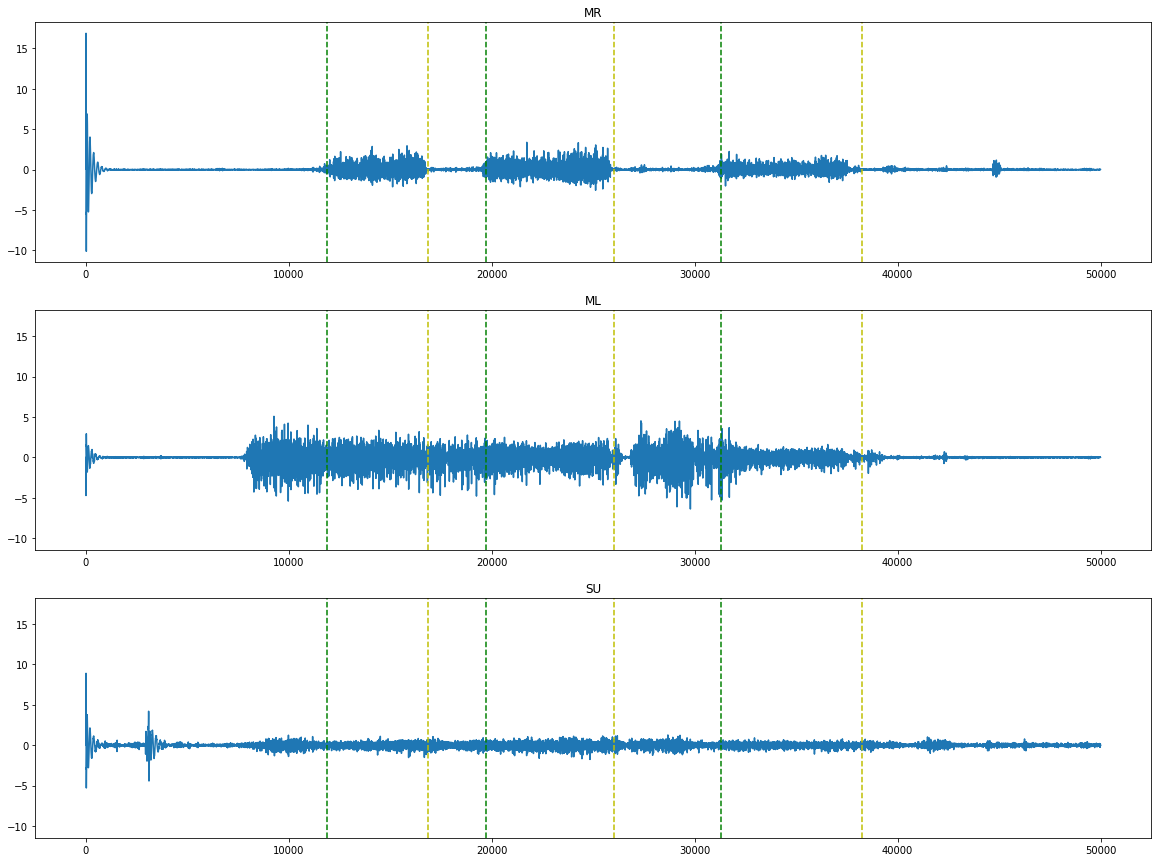

In [27]:
range_min = 0
range_max = 25000
def plot_data(data, loc):    
    fig, axes = plt.subplots(3,1, figsize=(20, 15), sharey=True) # ensures that all subplots share the same x-axis and y-axis
    for i in range(3):
        axes[i].plot(data.iloc[range_min:range_max,i])
        axes[i].set_title(data.columns[i])
        for j in range(loc.shape[0]):
            axes[i].axvline(x=loc.iloc[j,0], color='g', linestyle='--')
            axes[i].axvline(x=loc.iloc[j,1], color='y', linestyle='--')
        
plot_data(df, loc)

### Data Preprocessing

In [28]:
range_min = 0
range_max = 25000

bites = np.zeros(data.shape[0], dtype=int)
for i in range(1, range_max*dsample_rate):
    if i < loc.iloc[0,0] or (i > loc.iloc[0,1] and i < loc.iloc[1,0]) or (i > loc.iloc[1,1] and i < loc.iloc[2,0]) or i > loc.iloc[2,1]:
        bites[i] = 0
    else:
        bites[i] = 1

df.loc[:,'Bites'] = bites[::dsample_rate]
x = df.iloc[range_min:range_max,:3].copy()
y = df.iloc[range_min:range_max,-1].copy()
print(x.shape)
print(y.shape)

(25000, 3)
(25000,)


### Sliding window

In [72]:
window_size = 1000  # Size of the sliding window
stride = 50  # Stride or step size between windows
channel = 0  # Channel to be used for training

# Generate sliding window subsequences
windows = []
labels = []
for i in range(0, len(x) - window_size + 1, stride):
    window = x.iloc[i:i+window_size, channel].copy()
    windows.append(window)
    labels.append(1 if np.mean(y.iloc[i:i+window_size-1])>=0.5 else 0)

# Convert to numpy arrays
windows = np.array(windows)
labels = np.array(labels)
# windows = pd.concat(windows)
# labels = pd.Series(labels)

# Flatten the windows to match the input shape of XGBoost
flattened_windows = windows.reshape(windows.shape[0], -1)
print(flattened_windows.shape)


(481, 1000)


In [73]:
x_train, x_test, y_train, y_test = train_test_split(flattened_windows, labels, test_size=0.2, random_state=0) # Split data for test and training

SC = StandardScaler()
x_train = pd.DataFrame(SC.fit_transform(x_train))
x_test = pd.DataFrame(SC.transform(x_test))

### Split dataset

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1) # Split data for test and training

SC = StandardScaler()
x_train = pd.DataFrame(SC.fit_transform(x_train))
x_test = pd.DataFrame(SC.transform(x_test))

### Batch

In [53]:
batch_size = 1000
intervals = 100
num_batches = len(x) // batch_size
col_size = 3

model_XGB = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100
)

first = True
for i in range(1):
    for start in range(0, len(x_train), batch_size):
        if first:
            first = False
            model_XGB.fit(x_train.iloc[start:start+batch_size], y_train.iloc[start:start+batch_size])
            continue
        model_XGB.fit(x_train.iloc[start:start+batch_size], y_train.iloc[start:start+batch_size], xgb_model=model_XGB)



### Model

In [74]:
model_XGB = xgb.XGBClassifier()
model_RF = RandomForestClassifier(n_estimators = 100, random_state=0)
model_XGB.fit(x_train, y_train)
model_RF.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [75]:
y_pred = model_RF.predict(x_test)
y_p = model_XGB.predict(x_test)
accuracy = accuracy_score(y_test, [q for q in y_pred])
accuracy_p = accuracy_score(y_test, [r for r in y_p])
print("Accuracy for RF: %.2f%%" % (accuracy * 100.0))
print("Accuracy for XGB: %.2f%%" % (accuracy_p * 100.0))

Accuracy for RF: 97.94%
Accuracy for XGB: 97.94%


### Confusion Matrix

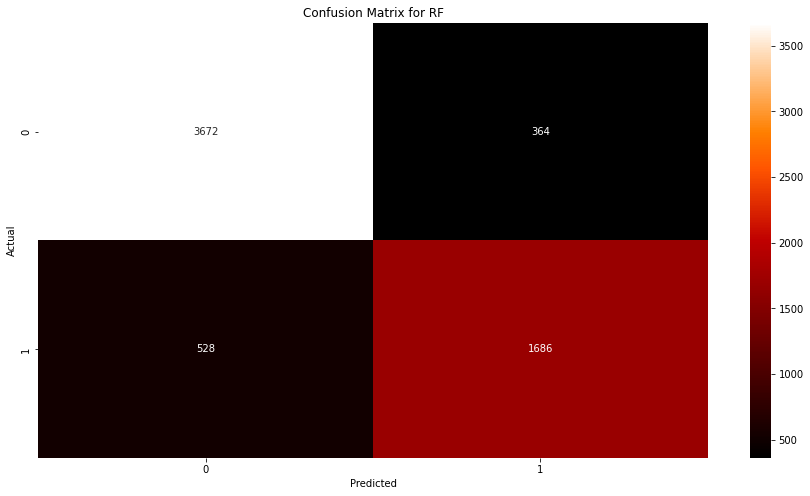

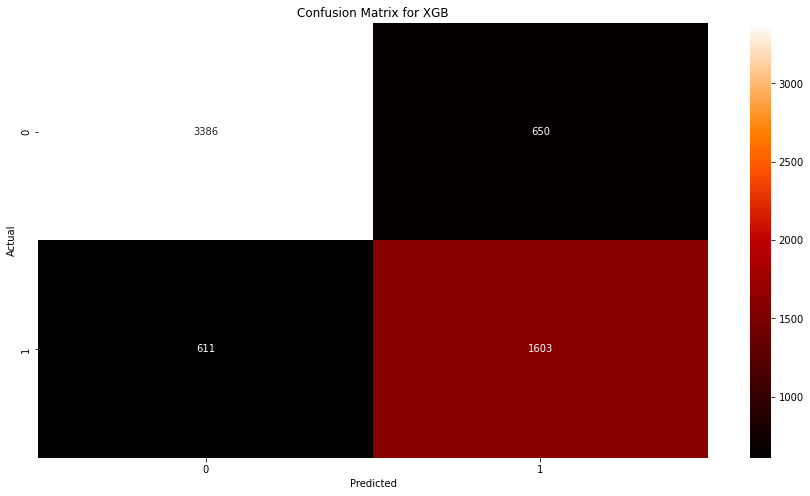

In [43]:
y_true = np.array(y_test)
y_pred = np.array(model_RF.predict(x_test))
y_pred_xgb = np.array(model_XGB.predict(x_test))

cm = confusion_matrix(y_true, y_pred)
cm_xgb = confusion_matrix(y_true, y_pred_xgb)
plt.figure(figsize = (15,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='gist_heat', cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for RF")
plt.show()
plt.figure(figsize = (15,8))
sns.heatmap(cm_xgb, annot=True, fmt='g', cmap='gist_heat',cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGB")
plt.show()

['0', '1', '2']


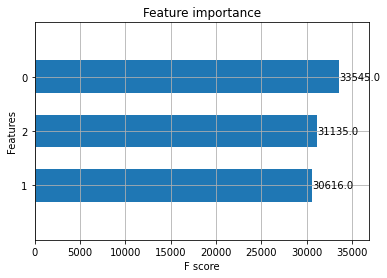

In [44]:
_ = plot_importance(model_XGB, height=0.6)
# model_XGB.get_booster().feature_names = ['EMG1', 'EMG2', 'EMG3']
print(model_XGB.get_booster().feature_names)